In [155]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn, optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange

import matplotlib.pyplot as plt

In [170]:
test_df = pd.read_csv('./house-prices-advanced-regression-techniques/test.csv')
df = pd.read_csv('./house-prices-advanced-regression-techniques/train.csv')

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [172]:
def drop_attributes(df):
    df.drop(['Alley'],axis=1,inplace=True)
    df.drop(['GarageYrBlt'],axis=1,inplace=True)
    df.drop(['PoolQC','Fence','MiscFeature'],axis=1,inplace=True)
    df.drop(['Id'],axis=1,inplace=True)
    return(df)

test_df_dropped = drop_attributes(test_df)
print("test_shape:", test_df_dropped.shape)
df_dropped = drop_attributes(df)
print("train_shape:", df_dropped.shape)

# id is removed from test, add later

test_shape: (1459, 74)
train_shape: (1460, 75)


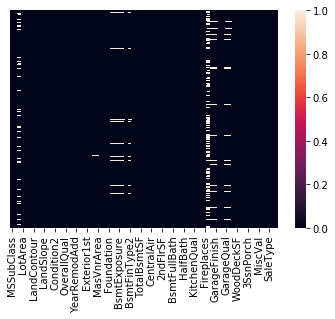

In [173]:
sn.heatmap(df.isnull(), yticklabels=False)

In [211]:
def fill_missing_vals(df):
    df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].mean())
    df['BsmtCond']=df['BsmtCond'].fillna(df['BsmtCond'].mode()[0])
    df['BsmtQual']=df['BsmtQual'].fillna(df['BsmtQual'].mode()[0])
    df['FireplaceQu']=df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])
    df['GarageType']=df['GarageType'].fillna(df['GarageType'].mode()[0])
    df['GarageFinish']=df['GarageFinish'].fillna(df['GarageFinish'].mode()[0])
    df['GarageQual']=df['GarageQual'].fillna(df['GarageQual'].mode()[0])
    df['GarageCond']=df['GarageCond'].fillna(df['GarageCond'].mode()[0])
    df['MasVnrType']=df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
    df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].mode()[0])
    df['BsmtFinType2']=df['BsmtFinType2'].fillna(df['BsmtFinType2'].mode()[0])
    df['BsmtExposure']=df['BsmtExposure'].fillna(df['BsmtExposure'].mode()[0])
    df['Foundation']=df['Foundation'].fillna(df['Foundation'].mode()[0])
    df['BsmtFinType1']=df['BsmtFinType1'].fillna(df['BsmtFinType1'].mode()[0])
    df['Electrical']=df['Electrical'].fillna(df['Electrical'].mode()[0])
    df['MSZoning']=df['MSZoning'].fillna(df['MSZoning'].mode()[0])
    df['Utilities']=df['Utilities'].fillna(df['Utilities'].mode()[0])
    df['BsmtFinSF1']=df['BsmtFinSF1'].fillna(df['BsmtFinSF1'].mode()[0])
    df['BsmtFinSF2']=df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mode()[0])
    df['BsmtUnfSF']=df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mode()[0])
    df['TotalBsmtSF']=df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mode()[0])
    df['BsmtFullBath']=df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])
    df['BsmtHalfBath']=df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])
    df['Functional']=df['Functional'].fillna(df['Functional'].mode()[0])
    df['GarageCars']=df['GarageCars'].fillna(df['GarageCars'].mode()[0])
    df['GarageArea']=df['GarageArea'].fillna(df['GarageArea'].mode()[0])
    df['KitchenQual']=df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])
    df['Exterior1st']=df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
    df['Exterior2nd']=df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

    df['SaleType']=df['SaleType'].fillna(df['SaleType'].mode()[0])

    
    return(df)
    
df_filled = fill_missing_vals(df_dropped)
test_df_filled = fill_missing_vals(test_df_dropped)

In [215]:
df_filled.isnull().values.any()

False

In [216]:
test_df_filled.isnull().values.any()


False

In [217]:
# encode

def convert_categorical(category, df):
    s = str(category)
    df = pd.get_dummies(df, columns=[s])
    return df


def encode_df(df):
    
    df_encoded = convert_categorical('Street', df)
    df_encoded = convert_categorical('MSZoning', df_encoded)
    df_encoded = convert_categorical('LotShape', df_encoded)
    df_encoded = convert_categorical('LandContour', df_encoded)
    df_encoded = convert_categorical('Utilities', df_encoded)
    df_encoded = convert_categorical('LotConfig', df_encoded)
    df_encoded = convert_categorical('LandSlope', df_encoded)
    df_encoded = convert_categorical('Neighborhood', df_encoded)
    df_encoded = convert_categorical('Condition1', df_encoded)
    df_encoded = convert_categorical('Condition2', df_encoded)
    df_encoded = convert_categorical('BldgType', df_encoded)
    df_encoded = convert_categorical('HouseStyle', df_encoded)
    df_encoded = convert_categorical('RoofStyle', df_encoded)
    df_encoded = convert_categorical('RoofMatl', df_encoded)
    df_encoded = convert_categorical('Exterior1st', df_encoded)
    df_encoded = convert_categorical('Exterior2nd', df_encoded)
    df_encoded = convert_categorical('MasVnrType', df_encoded)
    df_encoded = convert_categorical('ExterQual', df_encoded)
    df_encoded = convert_categorical('ExterCond', df_encoded)
    df_encoded = convert_categorical('Foundation', df_encoded)
    df_encoded = convert_categorical('BsmtQual', df_encoded)
    df_encoded = convert_categorical('BsmtCond', df_encoded)
    df_encoded = convert_categorical('BsmtExposure', df_encoded)
    df_encoded = convert_categorical('BsmtFinType1', df_encoded)
    df_encoded = convert_categorical('BsmtFinType2', df_encoded)
    df_encoded = convert_categorical('Heating', df_encoded)
    df_encoded = convert_categorical('HeatingQC', df_encoded)
    df_encoded = convert_categorical('CentralAir', df_encoded)
    df_encoded = convert_categorical('Electrical', df_encoded)
    df_encoded = convert_categorical('KitchenQual', df_encoded)
    df_encoded = convert_categorical('Functional', df_encoded)
    df_encoded = convert_categorical('FireplaceQu', df_encoded)
    df_encoded = convert_categorical('GarageType', df_encoded)
    df_encoded = convert_categorical('GarageFinish', df_encoded)
    df_encoded = convert_categorical('GarageQual', df_encoded)
    df_encoded = convert_categorical('GarageCond', df_encoded)
    df_encoded = convert_categorical('PavedDrive', df_encoded)
    df_encoded = convert_categorical('SaleType', df_encoded)
    df_encoded1 = convert_categorical('SaleCondition', df_encoded)


    return(df_encoded1)



df_encoded = encode_df(df_filled)

train_cols=[]
for col in df_encoded.columns:
    train_cols.append(col)

test_df_encoded = encode_df(test_df_filled)

test_cols=[]
for col in test_df_encoded.columns:
    test_cols.append(col)
    
diff =[]

for a in train_cols:
    if a not in test_cols:
        diff.append(a)
        
for a in diff[1:]:  # exclude SalePrice
    df_encoded.drop([a],axis=1,inplace=True)
    
print(df_encoded.shape)
print(test_df_encoded.shape)

(1460, 259)
(1459, 258)


In [218]:
df_encoded = df_encoded.astype(float)
df_encoded.info() # all float

test_df_encoded = test_df_encoded.astype(float)
test_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 259 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(259)
memory usage: 2.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 258 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(258)
memory usage: 2.9 MB


In [219]:
sale_price = df_encoded['SalePrice'] # make a copy for later
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns = df_encoded.columns)
df_scaled['SalePrice'] = sale_price #restore SalePrice values
df_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [220]:
test_df_scaled =  pd.DataFrame(scaler.fit_transform(test_df_encoded), columns = test_df_encoded.columns)
test_df_scaled.head()
#test df is ready

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.000000,0.329609,0.184147,0.444444,0.625,0.625954,0.183333,0.000000,0.116708,0.094364,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.335196,0.232124,0.555556,0.625,0.603053,0.133333,0.083721,0.230175,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.296089,0.224197,0.444444,0.500,0.900763,0.800000,0.000000,0.197257,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.235294,0.318436,0.154326,0.555556,0.625,0.908397,0.800000,0.015504,0.150125,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.588235,0.122905,0.064121,0.777778,0.500,0.862595,0.700000,0.000000,0.065586,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [221]:
train = df_scaled.iloc[:1410]
val = df_scaled.iloc[1410:]
X_train, y_train= train.drop('SalePrice', axis=1), train['SalePrice']
print(X_train.shape)

X_val, y_val = val.drop('SalePrice', axis=1), val["SalePrice"]
print(X_val.shape)

(1410, 258)
(50, 258)


In [222]:
train_batch = np.array_split(X_train, 50) 
label_batch = np.array_split(y_train, 50) # 50 sections/batches

val_batch = np.array_split(X_val, 50)
val_label_batch = np.array_split(y_val, 50)


#Split an array into multiple sub-arrays.
#numpy.array_split(ary, indices_or_sections, axis=0)[source]

In [223]:
# convert to torch
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    


In [224]:
print(len(train_batch))
print(len(label_batch))
print(len(val_batch))
print(len(val_label_batch))

50
50
50
50


In [244]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(258, 144)
        self.fc2 = nn.Linear(144, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x

In [256]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0006)
epochs = 200
train_losses, test_losses = [], []
for e in tnrange(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_losses.append(train_loss/len(train_batch)) # for the plot
    print("Train_Loss: {:.3f}.. ".format(train_loss/len(train_batch)))

/home/mainak09/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


Train_Loss: 12.249.. 
Train_Loss: 9.349.. 
Train_Loss: 8.012.. 
Train_Loss: 7.115.. 
Train_Loss: 6.409.. 
Train_Loss: 5.818.. 
Train_Loss: 5.303.. 
Train_Loss: 4.861.. 
Train_Loss: 4.480.. 
Train_Loss: 4.146.. 
Train_Loss: 3.843.. 
Train_Loss: 3.562.. 
Train_Loss: 3.300.. 
Train_Loss: 3.059.. 
Train_Loss: 2.839.. 
Train_Loss: 2.637.. 
Train_Loss: 2.450.. 
Train_Loss: 2.276.. 
Train_Loss: 2.112.. 
Train_Loss: 1.956.. 
Train_Loss: 1.808.. 
Train_Loss: 1.668.. 
Train_Loss: 1.534.. 
Train_Loss: 1.406.. 
Train_Loss: 1.285.. 
Train_Loss: 1.169.. 
Train_Loss: 1.058.. 
Train_Loss: 0.953.. 
Train_Loss: 0.853.. 
Train_Loss: 0.760.. 
Train_Loss: 0.674.. 
Train_Loss: 0.595.. 
Train_Loss: 0.525.. 
Train_Loss: 0.466.. 
Train_Loss: 0.420.. 
Train_Loss: 0.386.. 
Train_Loss: 0.363.. 
Train_Loss: 0.349.. 
Train_Loss: 0.339.. 
Train_Loss: 0.333.. 
Train_Loss: 0.328.. 
Train_Loss: 0.324.. 
Train_Loss: 0.321.. 
Train_Loss: 0.318.. 
Train_Loss: 0.314.. 
Train_Loss: 0.311.. 
Train_Loss: 0.308.. 
Train_Loss: 

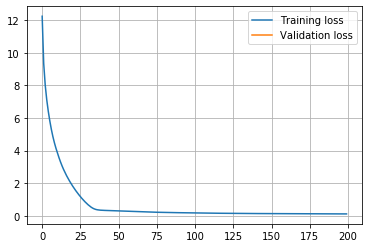

In [257]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.grid()
plt.legend()

In [259]:
# Pass some values from the train_set through the model, sanity check.

print("Predicted Values:\n")
with torch.no_grad():
    for i in range(5):
        m = model(train_batch[0][i])
        print(m.item())
        
print("\n\nActual Values: \n\n208500 \n181500 \n223500 \n140000 \n250000")

Predicted Values:

207091.671875
189334.109375
222642.578125
175634.53125
293022.375


Actual Values: 

208500 
181500 
223500 
140000 
250000


In [260]:
test = test_df_scaled
X_test=test
test_batch = np.array_split(X_test, 50) 
res =[]


for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()

with torch.no_grad():
    for i in range(len(test_batch)):
        output = model(test_batch[i])
        #print(output)
        for d in output:
            res.append(d.numpy().item())
            

ids = [a for a in range(1461, 2920)]



print(res[659:665])

[116844.796875, 75341.5703125, 127700.484375, 87211.5625, 145002.53125, 114019.75]


In [264]:
submission = pd.read_csv('./house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = res
submission.to_csv('./house-prices-advanced-regression-techniques/sample_submission.csv', index=False)
submission

,Id,SalePrice
0,1461,122655.031250
1,1462,147105.703125
2,1463,177752.250000
3,1464,185486.937500
4,1465,181180.468750
...,...,...
1454,2915,74374.015625
1455,2916,63671.500000
1456,2917,156343.250000
1457,2918,117257.515625


In [265]:
x = pd.read_csv('./house-prices-advanced-regression-techniques/sample_submission.csv')
x

,Id,SalePrice
0,1461,122655.031250
1,1462,147105.703125
2,1463,177752.250000
3,1464,185486.937500
4,1465,181180.468750
...,...,...
1454,2915,74374.015625
1455,2916,63671.500000
1456,2917,156343.250000
1457,2918,117257.515625


# To Do:
1. Form a validation set and visualise the loss metrics through the epochs.
2. Make sure the model is not overfittng.